In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline # plot in cell
from sklearn import metrics
import pandas as pd
from scipy import signal
from scipy import stats


import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# for svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

feature_names = ['mean_x', 'mean_y', 'mean_z', 
                'rms_x', 'rms_y', 'rms_z',
                'std_x', 'std_y', 'std_z',
                'med_x', 'med_y', 'med_z',
                'min_x', 'min_y', 'min_z',
                'max_x', 'max_y', 'max_z']

target_names = ['Jogging','Walking','Stairs up','Stairs down','Sitting','Standing']
                
def featuresFromBuffer(at):
    feat = np.zeros(18)
    x = np.array(at.iloc[:,0], dtype=np.float64) 
    y = np.array(at.iloc[:,1], dtype=np.float64)
    z = np.array(at.iloc[:,2], dtype=np.float64)
    
    means = [np.mean(i) for i in [x, y, z]]
    feat[0:3] = means
    
    rms = [np.sqrt(np.mean(i**2)) for i in [x, y, z]]
    feat[3:6] = rms
    
    std = [np.std(i) for i in [x, y, z]]
    feat[6:9] = std
    
    med = [np.median(i) for i in [x, y, z]]
    feat[9:12] = med
       
    Range1 = [ np.amin(i) for i in [x, y, z]]   
    feat[12:15] = Range1
    Range2 = [ np.amax(i) for i in [x, y, z]]    
    feat[15:18] = Range2
    
    return feat

In [2]:
dt = pd.read_excel (r'F:\Program\OneDrive\TLNC\ISI\data\data.xlsx')
dt.columns
dt.shape

Index(['Person', 'State', 'x', 'y', 'z'], dtype='object')

(1048575, 5)

df_test = dt.groupby(['Person'])
df_test.first()
data = df_test.get_group(33.0)
data
type(data)

In [3]:
df = dt.groupby(['Person','State'])
df.first()

x      y          z
Person State                             
1.0    Downstairs -0.15   9.15  -0.340000
       Jogging     4.48  14.18  -2.110000
       Upstairs    3.53  10.76  -3.060000
       Walking     0.69  10.80  -2.030000
2.0    Jogging     5.98   3.87  -6.280000
...                 ...    ...        ...
36.0   Jogging    -9.19  16.36  14.628253
       Sitting    -5.71  -2.34   7.354988
       Standing   -0.11   9.58   2.492524
       Upstairs    1.46   8.50   0.844462
       Walking    -2.87  10.46   0.231546

[172 rows x 3 columns]

In [4]:
Jogging = df.get_group((33.0,'Jogging'))
Walking = df.get_group((33.0,'Walking'))
Upstairs = df.get_group((33.0,'Upstairs'))
Downstairs = df.get_group((33.0,'Downstairs'))
Sitting = df.get_group((33.0,'Sitting'))
Standing = df.get_group((33.0,'Standing'))

Jogging


,x,y,z
0,-0.694638,12.680544,0.503953
1,5.012288,11.264028,0.953424
2,4.903325,10.882658,-0.081722
3,-0.612916,18.496431,3.023717
4,-1.184970,12.108489,7.205164
...,...,...,...
8484,2.642348,9.888372,0.000000
8485,2.560625,9.466142,-0.081722
8486,1.457377,10.882658,-0.653777
8487,2.410802,9.534244,-0.503953


Jogging.isnull().sum().sum()
Walking.isnull().sum().sum()
Upstairs.isnull().sum().sum()
Downstairs.isnull().sum().sum()
Sitting.isnull().sum().sum()
Standing.isnull().sum().sum()

In [30]:
# Split dataset to 2 parts: Train (60%) - Test (40%)\n",

window_size = 16
stride = 8 #step
ratio = 0.6

X_jog_train = [Jogging[i:i+window_size] for i in range(0, int(len(Jogging)*ratio), stride)] 
X_jog_test = [Jogging[i:i+window_size] for i in range(int(len(Jogging)*ratio), len(Jogging), stride) 
                                            if i+window_size<=len(Jogging)]

X_walk_train = [Walking[i:i+window_size] for i in range(0, int(len(Walking)*ratio), stride)]
X_walk_test = [Walking[i:i+window_size] for i in range(int(len(Walking)*ratio), len(Walking),stride)
                                           if i+window_size<=len(Walking)]

X_up_train = [Upstairs[i:i+window_size] for i in range(0, int(len(Upstairs)*ratio), stride)] 
X_up_test = [Upstairs[i:i+window_size] for i in range(int(len(Upstairs)*ratio), len(Upstairs), stride) 
                                            if i+window_size<=len(Upstairs)]

X_down_train = [Downstairs[i:i+window_size] for i in range(0, int(len(Downstairs)*ratio), stride)] 
X_down_test = [Downstairs[i:i+window_size] for i in range(int(len(Downstairs)*ratio), len(Downstairs), stride) 
                                            if i+window_size<=len(Downstairs)]

X_sit_train = [Sitting[i:i+window_size] for i in range(0, int(len(Sitting)*ratio), stride)]
X_sit_test = [Sitting[i:i+window_size] for i in range(int(len(Sitting)*ratio), len(Sitting),stride)
                                           if i+window_size<=len(Sitting)]

X_stand_train = [Standing[i:i+window_size] for i in range(0, int(len(Standing)*ratio), stride)] 
X_stand_test = [Standing[i:i+window_size] for i in range(int(len(Standing)*ratio), len(Standing), stride) 
                                            if i+window_size<=len(Standing)]


print ('X_jog_train: ', len(X_jog_train))
print ('X_jog_test: ', len(X_jog_test))

print ('X_stand_train: ', len(X_stand_train))
print ('X_stand_test: ', len(X_stand_test))

print ('X_up_train: ', len(X_up_train))
print ('X_up_test: ', len(X_up_test))

print ('X_down_train: ', len(X_down_train))
print ('X_down_test: ', len(X_down_test))

print ('X_sit_train: ', len(X_sit_train))
print ('X_sit_test: ', len(X_sit_test))

print ('X_walk_train: ', len(X_walk_train))
print ('X_walk_test: ', len(X_walk_test))


X_jog_train:  221
X_jog_test:  146
X_stand_train:  121
X_stand_test:  79
X_up_train:  166
X_up_test:  109
X_down_train:  341
X_down_test:  225
X_sit_train:  244
X_sit_test:  161
X_walk_train:  1118
X_walk_test:  744


In [34]:
train_data = []
train_label = []

test_data = []
test_label = []

for acts in X_jog_train:
    train_data.append(acts)
    train_label.append(0)

for acts in X_walk_train:
    train_data.append(acts)
    train_label.append(1)

for acts in X_up_train:
    train_data.append(acts)
    train_label.append(2)

for acts in X_down_train:
    train_data.append(acts)
    train_label.append(3)

for acts in X_sit_train:
    train_data.append(acts)
    train_label.append(4)
    
for acts in X_stand_train:
    train_data.append(acts)
    train_label.append(5)
    
print('train-data length: ', len(train_data) )
print('train-label length: ', len(train_label) )
      
# For TEST
for acts in X_jog_test:
    test_data.append(acts)
    test_label.append(0)
    
for acts in X_walk_test:
    test_data.append(acts)
    test_label.append(1)

for acts in X_up_test:
    test_data.append(acts)
    test_label.append(2)

for acts in X_down_test:
    test_data.append(acts)
    test_label.append(3)
    
for acts in X_sit_test:
    test_data.append(acts)
    test_label.append(4)
    
for acts in X_stand_test:
    test_data.append(acts)
    test_label.append(5)

print('test-data length: ', len(test_data))
print('test-label length: ', len(test_label))

train-data length:  2211
train-label length:  2211
test-data length:  1464
test-label length:  1464


In [35]:
# Features set

train_features = []
test_features = []
for action in train_data:
    feat = featuresFromBuffer(action)
    train_features.append(feat)  

for action in test_data:
    feat = featuresFromBuffer(action)
    test_features.append(feat)

len(train_features)
len(test_features)


2211

1464

In [36]:
print(type(train_features[0][0]))

<class 'numpy.float64'>


In [37]:
# beginning of classification:
#https://www.kaggle.com/beagle01/prediction-with-gradient-boosting-classifier

print("Gradient Boosting Decision Tree:")
from sklearn.ensemble import GradientBoostingClassifier
clf1 = GradientBoostingClassifier(learning_rate=0.05,max_depth=3,n_estimators=100).fit(train_features, train_label)
print('Accuracy of GBDT classifier on training set: {:.3f}'
     .format(clf1.score(train_features, train_label)))
print('Accuracy of GBDT classifier on test set: {:.3f}'
     .format(clf1.score(test_features, test_label)))


print("\n\nDecision Tree:") 
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_decision_tree  

clf2 = DecisionTreeClassifier(max_depth=4).fit(train_features, train_label)

print('Accuracy of Decision Tree classifier on training set: {:.3f}'.format(clf2.score(train_features, train_label)))
print('Accuracy of Decision Tree classifier on test set: {:.3f}'
.format(clf2.score(test_features, test_label)))


print("\n\nSVM:")
clf3 = SVC(C=100, gamma='scale').fit(train_features, train_label)
print("Accuracy on training set: {:.2f}".format(clf3.score(train_features, train_label)))
print("Accuracy on test set: {:.2f}".format(clf3.score(test_features, test_label)))


print('\n\nRandom Forests: ')
from sklearn.ensemble import RandomForestClassifier
clf4 = RandomForestClassifier(n_estimators=200, random_state=0).fit(train_features, train_label)

print('Accuracy of RF classifier on training set: {:.3f}'
     .format(clf4.score(train_features, train_label)))
print('Accuracy of RF classifier on test set: {:.3f}'
     .format(clf4.score(test_features, test_label)))


print('\n\nKNeighbor: ')
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance').fit(train_features, train_label)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(train_features, train_label)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(test_features, test_label)))

Gradient Boosting Decision Tree:
Accuracy of GBDT classifier on training set: 0.995
Accuracy of GBDT classifier on test set: 0.932


Decision Tree:
Accuracy of Decision Tree classifier on training set: 0.885
Accuracy of Decision Tree classifier on test set: 0.871


SVM:
Accuracy on training set: 0.98
Accuracy on test set: 0.94


Random Forests: 
Accuracy of RF classifier on training set: 1.000
Accuracy of RF classifier on test set: 0.935


KNeighbor: 
Accuracy of K-NN classifier on training set: 1.00
Accuracy of K-NN classifier on test set: 0.93


print('\n\n KNeighbor: ')
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance').fit(train_features, train_label)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(train_features, train_label)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(test_features, test_label)))

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score


y_pred = knn.predict(test_features)

f1_score(test_label, y_pred, average='macro')
recall_score(test_label, y_pred, average='macro')
precision_score(test_label, y_pred, average='macro')

f1_score(test_label, y_pred, average='micro')
recall_score(test_label, y_pred, average='micro')
precision_score(test_label, y_pred, average='micro')

Confusion matrix, without normalization
[[143   1   0   1   0   1]
 [  0 725   5  14   0   0]
 [  0  35  35  39   0   0]
 [  0   3   4 218   0   0]
 [  0   0   0   0 161   0]
 [  0   0   0   0   0  79]]
Normalized confusion matrix
[[0.98 0.01 0.   0.01 0.   0.01]
 [0.   0.97 0.01 0.02 0.   0.  ]
 [0.   0.32 0.32 0.36 0.   0.  ]
 [0.   0.01 0.02 0.97 0.   0.  ]
 [0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   1.  ]]


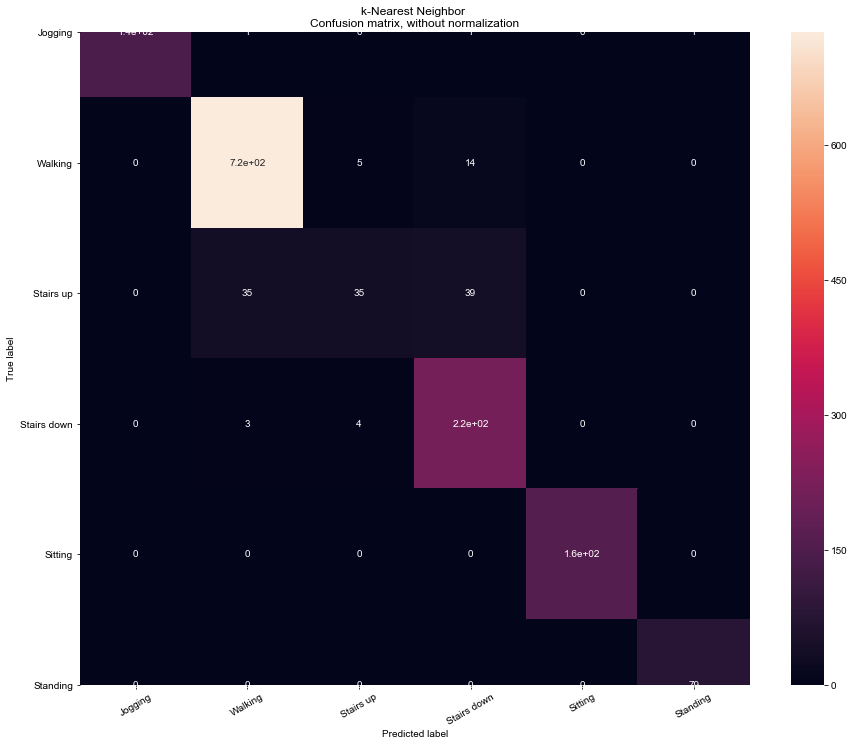

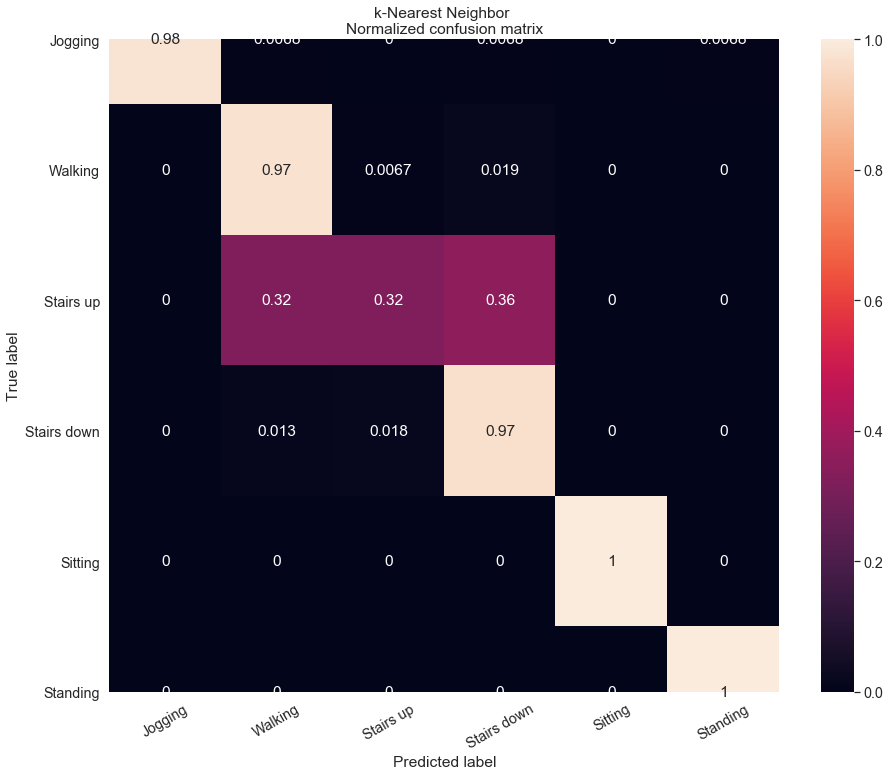


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       146
           1       0.95      0.97      0.96       744
           2       0.80      0.32      0.46       109
           3       0.80      0.97      0.88       225
           4       1.00      1.00      1.00       161
           5       0.99      1.00      0.99        79

    accuracy                           0.93      1464
   macro avg       0.92      0.87      0.88      1464
weighted avg       0.93      0.93      0.92      1464



In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sb
from sklearn.utils.multiclass import unique_labels

y_pred = knn.predict(test_features)
lables = np.concatenate([target_names, ])

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False, title=None):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize = (15,12))
    #Create a 2-dim array include: rows, columns, data
    dataFrame = pd.DataFrame(cm)
    #create a heatmap, annot = True: add text on each cell over heatmap
    sb.heatmap(dataFrame, annot = True)  
    ax.set(xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

    sb.set(font_scale = 1.3)

np.set_printoptions(precision=2) #lam tron

plot_confusion_matrix(test_label, y_pred, classes=lables,
        title='k-Nearest Neighbor \nConfusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(test_label, y_pred, classes=lables, normalize=True,
        title='k-Nearest Neighbor \nNormalized confusion matrix')

plt.show()
print ("\nClassification Report: ")
print (classification_report(test_label, y_pred))


6


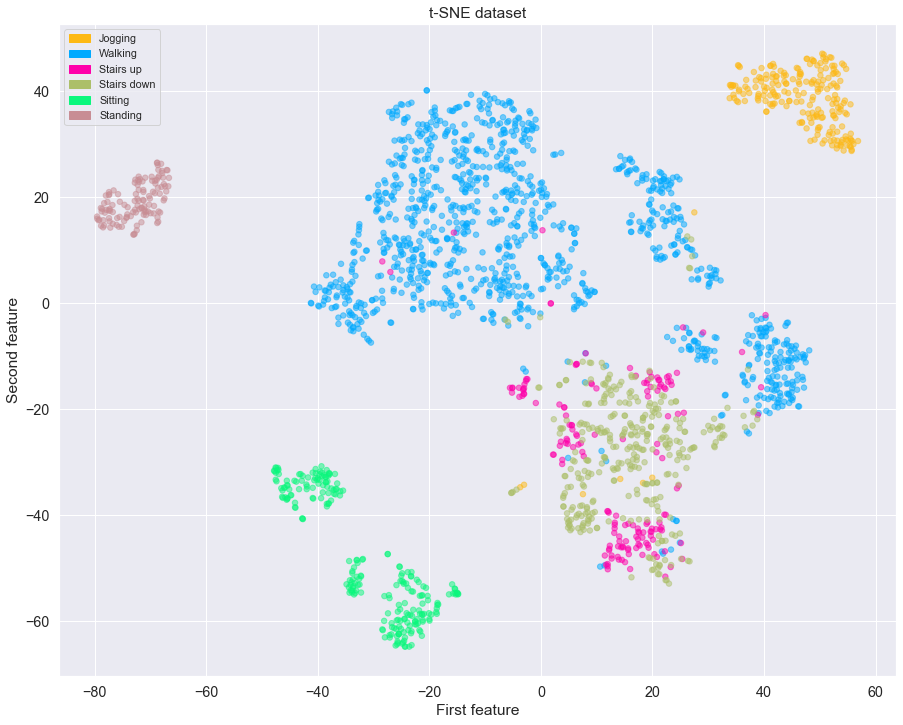

In [44]:
# t-SNE

import numpy
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn import neighbors
import graphviz 
from sklearn.tree import export_graphviz
import matplotlib.patches as mpatches


def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)
    print(num_labels)

    # create a mesh (lưới) to plot the boundaries (đường biên)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1   # min & max for feature 1 ((column 0)) 
                    # X[row, column]
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1   # min & max for feature 2 (column 1)
    

    # marker_shapes = ['v', 's', 'o', '^', '*']
    # Create array color of 7 behaviors
    colors = ['#fdb915', '#00AAFF', '#FF00AA', '#acbf69', 
              '#0bf77d','#c88d94',
              '#24bca8', '#c04e01','#8f8ce7']
    cmap = ListedColormap(colors) 
    
   # Generate a colormap index based on discrete intervals
    norm = BoundaryNorm(numpy.arange(0, num_labels+1, 1), ncolors=num_labels) 
    
    plt.figure(figsize=(15, 12))  # độ dài row & column của 
    
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=cmap, norm=norm, alpha=0.5, lw=1)
                #edgecolor='black'
    
    # Create array h[] chứa chú thích behaviors & colors tương ứng
    h = []
    for c in range(0, num_labels):
        # tạo chú thích = mpatches.Patch
        h.append(mpatches.Patch(color=colors[c], label=class_labels[c])) 
    plt.legend(handles=h, fontsize = 'x-small') # show ghi chu
    
    plt.xlabel('First feature')
    plt.ylabel('Second feature')
    plt.title('t-SNE dataset')

    plt.show()
    
X_visual = train_features
y_visual = np.array(train_label, dtype=np.uint8) # np.array: create array
                                                    # np.uint8: unsigned integer
from sklearn.manifold import TSNE

# fit X_visual into embedding space in low-dimensional space and return  array (n_samples, n_components) 
X_tsne = TSNE(random_state=1000,n_components=2, perplexity=30.0, learning_rate=300.0).fit_transform(X_visual)
plot_labelled_scatter(X_tsne, y_visual,['Jogging','Walking','Stairs up',
                                        'Stairs down','Sitting','Standing'])